In [20]:
# install.packages("BiocManager")
# library("BiocManager")

# BiocManager::install("rstan")
# BiocManager::install("outbreaks")

library(rstan)
library(outbreaks)
library(tidyverse)
library(gridExtra)

abstract: This tutorial shows how to build, fit, and criticize disease transmission models in Stan, and should be useful to researchers interested in modeling the COVID-19 outbreak and doing Bayesian inference. Bayesian modeling provides a principled way to quantify uncertainty and incorporate prior knowledge into the model. What is more, Stan's main inference engine, Hamiltonian Monte Carlo sampling, is amiable to diagnostics, which means we can verify whether our inference is reliable. Stan is an expressive probabilistic programing language that abstracts the inference and allows users to focus on the modeling. The resulting code is readable and easily extensible, which makes the modeler's work more transparent and flexible. In this tutorial, we demonstrate with a simple Susceptible-Infected-Recovered (SIR) model how to formulate, fit, and diagnose a compartmental model in Stan. We also introduce more advanced topics which can help practitioners fit sophisticated models; notably, how to use simulations to probe our model and our priors, and computational techniques to scale ODE-based models.

Transmission models of infectious diseases can help answer questions about past and future transmission,
including the effects of interventions.

<!- Such models can be expressed in several ways. -->

<!- The two broad categories are population-based and agent-based models.  -->

_Population-based models_ subdivide the total population into homogeneous groups,
called _compartments_.
The flows between compartments can be described by a system of differential equations.
Individuals within a compartment are considered to be in the same state
(e.g. susceptible, infected, etc.).
Moreover, the time-dependent volume of each compartment
solves a system of ordinary differential equations (ODEs).
Compartment models are relatively easy to formulate
and computationally tractable.

<!- Agent-based models simulate inidivuals (called _agents_) -->

<!- and their interaction with an environment over time. -->

<!- This approach explicitly accounts for heterogeneity amongst individuals -->

<!- but yields models which are difficult to handle, -->

<!- both mathematically and computationally. -->

<!- By contrast, compartment models are relatively easy to formulate -->
<!- and computationally tractable. -->

<!- and model the size of each compartment via a set of either continuous or discrete-time differential equations. -->

<!- Individuals within each compartment are considered to have the same state with respect to the disease in question.  -->

<!- Time-dependent number of individuals in each group is a solution of an ordinary differential equations system relating all the quantities. Stochastic processes, such as Markov chains, are also used to describe transitions between compartments. Agent-based models are used to simulate individuals (agents) and their interactions with an environment over time. Such models allow to account for heterogeneity in an explicit way but are very computationally demanding, especially when the objective is statistical inference.]. -->

<!- Compartmental models described by ordinary differential equations (ODEs) have gained popularity due to several factors:  -->

<!- they are relatively easy to formulate, are computationally more tractable than agent-based models,  -->

<!- and in the simplest cases can be solved and/or analysed analytically.  -->

<!- In practice, the volumes of some compartments and most parameters driving the dynamic are latent, -->

<!- and thus need to be inferred.  -->

<!- Statistical inference for ODEs is a hard task and should be treated separately from the model formulation. -->

<!- The ongoing pandemic of the Coronavirus COVID-19 has led to an increased interest in statistical disease modeling. Indeed, transmission models of infectious diseases can help answer questions about forecasting and effects of interventions. Such models can be expressed in several ways^[The three broad categories are population-based, agent-based or stochastic models. Population-based models subdivide the total population into homogeneous groups (compartments) and model the volume of each group via a set of continuous-time differential equations or discrete-time difference equations. Individuals within each compartment are considered to have the same state with respect to the disease in question. Time-dependent number of individuals in each group is a solution of an ordinary differential equations (ODEs) system relating all the quantities. Agent-based models are used to simulate individuals (agents) and their interactions with an environment over time. Such models allow to account for heterogeneity in an explicit way but are very computationally demanding. Stochastic processes, such as Markov chains, are also used to describe transitions between compartments.]. Compartmental models described by ODEs have gained popularity due to several factors: they are relatively easy to formulate, require less computational time than agent-based models, and in the simplest case can be solved and/or analysed analytically. However in practice, the volumes of some compartments and most parameters driving the dynamic are latent, and thus need to be inferred. Statistical inference for ODEs is a hard task and should be treated separately from the model formulation. -->

In this tutorial, we demonstrate with a simple example how
to formulate and fit a typical compartmental model in Stan.
Stan is a probabilistic programming framework designed to let the user focus on modeling, while inference happens under the hood [@Carpenter_stan_2017]. This allows for faster implementation and extension of epidemiological models through a principled modeling workflow, and is thus particularly useful when handling rapidly evolving data and knowledge.
Stan is an expressive language that supports many probability densities, matrix operations, and numerical ODE solvers.
We can combine all these elements to specify a data generating process.
We can also compute useful epidemiological parameters,
such as the _basic reproduction number_, $R_0$, and make predictions.

<!- $R_0$ is defined as the expected number of secondary infections produced from one infected individual in a fully susceptible population through the entire duration of the infectious period. -->

<!- $R_0 > 1$ indicates a sustainable infection, -->

<!- which can lead to a major outbreak, -->

<!- while $R_0 < 1$ suggests, under stable conditions, that the infection will die out. -->

<!- ^[Two crucial numbers quantifying a disease are the *basic reproduction number* $R_0$ and the *effective reproduction number* $R_t.$ The basic reproduction number, $R_0$, is the expected number of secondary infections produced from one infected individual in a fully susceptible population through the entire duration of the infectious period. Values of $R_0$ greater than one indicate a sustainable infection, when a major outbreak to be foreseen, while values below one indicate, under stable conditions, a potentially small outbreak and that the infection will die out.]. -->

Generative models formulated in Stan can be used both for simulation and inference.
Stan bolsters several inference methods: full Bayesian inference using Markov chains Monte Carlo (MCMC), approximate Bayesian inference with variational inference, and penalized maximum likelihood estimation. We focus on Bayesian inference with MCMC.
Bayesian inference gives us a principled quantification of uncertainty and the ability to incorporate domain knowledge in the form of priors, while MCMC is a reliable and flexible algorithm.
In addition, Stan provides diagnostic tools to evaluate both the inference (e.g. accuracy of the MCMC, convergence of chains) and the model (e.g. posterior predictive checks).

## Outline

Through the lens of the Susceptible-Infected-Recovered (SIR) model, we show how to put together a principled Bayesian workflow in Stan, allowing a faster development of reliable epidemiological models.
In Section 1, we introduce how to build, fit, and diagnose compartment models in Stan.
The next sections discuss topics that can help practitioners fit more complex models.
Section 2 reviews how we can use simulated data to examine our model and our priors,
and provides an introduction to inference calibration.
Section 3 offers a pragmatic discussion on how to efficiently implement
and scale up ODEs in Stan.

## Data

In this example, we examine an outbreak of influenza A (H1N1) in 1978 at a British boarding school.
The data consists of the daily number of students in bed, spanning over a time interval of 14 days.
There were 763 male students who were mostly full boarders and 512 of them became ill.
The outbreak lasted from the 22nd of January to the 4th of February.
It is reported that one infected boy started the epidemic, which spread rapidly in the relatively closed community of the boarding school.

<!- The original data were available only in a figure with some additional data in the [main text](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1603269/pdf/brmedj00115-0064.pdf).  -->

The data are freely available in the R package outbreaks, maintained as part of the [R Epidemics Consortium](http://www.repidemicsconsortium.org).

In [21]:
head(influenza_england_1978_school)

,date,in_bed,convalescent
,<date>,<int>,<int>
1,1978-01-22,3,0
2,1978-01-23,8,0
3,1978-01-24,26,0
4,1978-01-25,76,0
5,1978-01-26,225,9
6,1978-01-27,298,17


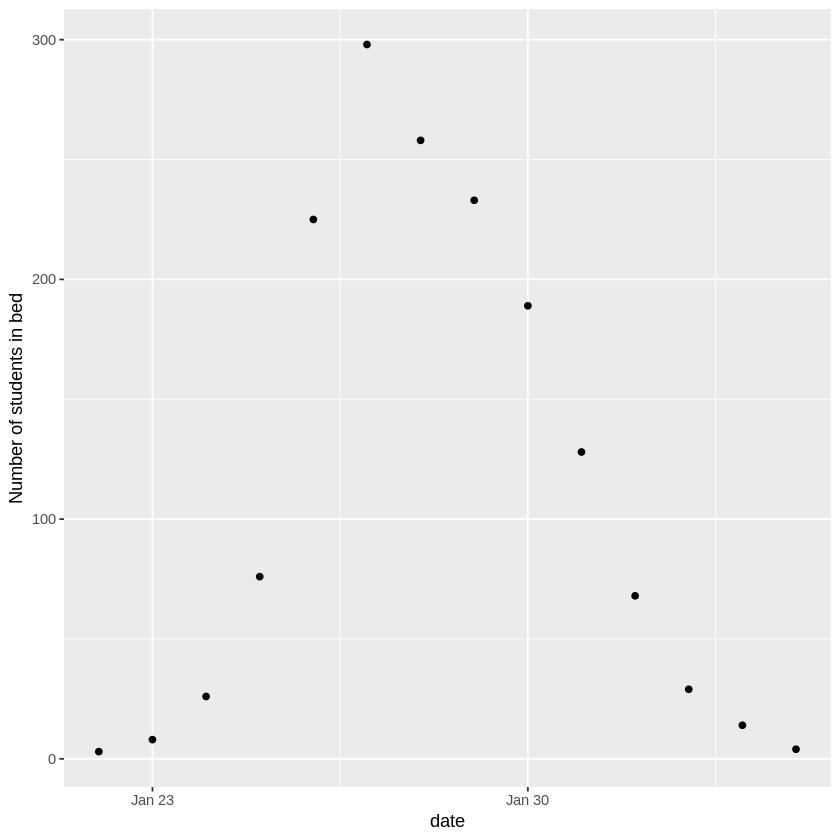

In [22]:
ggplot(data = influenza_england_1978_school) +
  geom_point(mapping = aes(x = date, y = in_bed)) +
  labs(y = "Number of students in bed")

## Mathematical transmission model

The Susceptible-Infected-Recovered (SIR) model splits the population in three time-dependent compartments: the susceptible, the infected (and infectious), and the recovered (and not infectious) compartments. When a susceptible individual comes into contact with an infectious individual, the former can become infected for some time, and then recover and become immune.
The dynamics can be summarized graphically:

The temporal dynamics of the sizes of each of the compartments are governed by the following  system of ODEs:

$$
\begin{aligned}
 \frac{dS}{dt} &= -\beta  S \frac{I}{N}\\
 \frac{dI}{dt} &= \beta  S  \frac{I}{N} - \gamma  I \\
 \frac{dR}{dt} &= \gamma I
\end{aligned}
$$
where

* $S(t)$ is the number of people susceptible to becoming infected (no immunity),

* $I(t)$ is the number of people currently infected (and infectious),

* $R(t)$ is the number of recovered people (we assume they remain immune indefinitely),

* $\beta$ is the constant rate of infectious contact between people,

* $\gamma$ the constant recovery rate of infected individuals.


Let's give some intuition behind these ODEs. The proportion of infected people among the population is $\frac{I}{N}$. At each time step, given uniform contacts, the probability for a susceptible person to become infected is thus $\beta\frac{I}{N}$, with $\beta$ the average number of contacts per person per time, multiplied by the probability of disease transmission when a susceptible and an infected subject come in contact. Hence, at each time step, $\beta  S \frac{I}{N}$ susceptible individuals become infected,  meaning $\beta  S \frac{I}{N}$ people leave the $S$ compartment and $\beta  S \frac{I}{N}$ people enter the $I$ compartment. Similarly, the recovery of an infected individual is taking place at rate $\gamma$, and thus the number of infected individuals decreases with speed $\gamma I$ while the number of recovered grows at the same speed.


The above model holds under several assumptions:

* births and deaths are not contributing to the dynamics and the total population $N=S+I+R$ remains constant,
* recovered individuals do not become susceptible again over time,

* the infection rate $\beta$ and recovery rate $\gamma$ are constant,

* the population is homogeneous,

* individuals meet any other individual uniformly at random (homogeneous mixing)
and recovery time follows an exponential distribution with mean $\frac{1}{\gamma}$.

* replacing the integer number of people in each compartement by a continuous approximation is legitimate (the population is big enough)

In case of boarding school data, the spread of the disease has started with one infected individual which leads to the initial conditions $I(0) = 1, S(0) = N-1, R(0) = 0.$


## Statistical model

We now introduce a _sampling distribution_ (also termed _likelihood_)
$$
  p(\mathcal Y \mid \theta)
$$
which tells us, given model parameters $\theta$, how to generate data $\mathcal Y$.
Inference reverse-engineers the data generating process
and asks: "given a model and observations, $\mathcal Y$,
what are plausible parameter values?"
In a Bayesian framework, the set of plausible values is characterized by
the _posterior distribution_,
$$
p(\theta \mid \mathcal Y).
$$
Bayes' rule teaches us that
$$
  p(\theta \mid \mathcal Y) \propto p(\mathcal Y \mid \theta) p(\theta)
$$
where $p(\mathcal Y \mid \theta)$ is the sampling distribution,
$p(\theta)$ the _prior_ distribution,
and $\propto$ stands for "proportional to".
The prior encodes information about the parameters we have
before observing the data.
To summarize, a Bayesian model couples a mathematical model of what we know about the parameters in the form of a prior and a sampling distribution, i.e. a model of the data generating process.

<!- ^[Given the a priori probability of the parameters $p(\theta)$ and the probability of the data given the parameters $p(y|\theta)$, Bayes rules tells us that the posterior distribution of the parameters $\theta$ is $p(\theta|y) \propto p(\theta)p(y|\theta)$]. Specifically, a Bayesian model requires a mathematical model of what we know about the parameters (i.e., a prior) and a model of what we know about the data generating process given the parameters (i.e., a sampling distribution). -->

### Sampling distribution

<!- Here we build a compatemental model.  -->

Given transmission parameters and initial conditions,
a compartmental model defines a unique solution for each of the compartments,
including the number of infected students, $I_\text{ODE}(t)$.
We want to link this solution to the observed data, i.e the number of students in bed, $I_\text{obs}(t)$, at each time point.

<!- (other states and parameters are latent).  -->
The latter is a noisy estimate of the true number of infected students.

<!- Likelihood allows us to match observed and predicted values to update the latent parameters. -->

We choose to model the number of students in bed with a count distribution --
the Negative Binomial.
This distribution allows us to use $I_\text{ODE}(t)$ as the expected value
and account for over-dispersion, through the parameter $\phi$:

$$
I_\text{obs}(t) \sim \text{NegBin}(I_\text{ODE}(t), \phi)
$$
This gives us $p(\mathcal Y \mid \theta)$, with $\theta = (\beta, \gamma, \phi)$, the parameters of the model.

### Prior distribution

We still need $p(\theta)$. With $\theta = (\beta, \gamma, \phi)$, we specify a prior distribution for each of the three parameters. One advantage of the Bayesian approach is that we can formally
incorporate prior knowledge about the parameters into the model.

<!- prior knowledge about the parameters can be formally incoperated into the model. -->

<!- Natural constraints on both $\beta$ and $\gamma$ are that they are positive.  -->

<!- Knowledge about the contact rate, infectiousness and recovery rate can be expressed in the form of priors. -->

For instance, we specify $\gamma \sim N(0.4, 0.5)$ (truncated at 0), which expresses our belief that $\gamma$ has to be positive, and that $P(\gamma \leq 1) = 0.9$
(i.e the probability that the recovery time is > 1 day is 0.9 *a priori*).
We can change this prior if more information becomes available, constraining our parameter estimation more tightly or, on the contrary,
increasing its variance.

Section 2 discusses how to check if our priors are consistent with available domain knowledge using _prior predictive checks_.


### Predictions and derived quantities

Once we fit the model and obtain a posterior distribution for $\theta$,
we can derive additional quantities of interests.
We can simulate predictions, $\mathcal Y_\mathrm{pred}$,
and work out the plausible range of new observations.
Because these predictions are based on the posterior, $p(\theta \mid \mathcal Y)$,
our simulations account for uncertainty both in the data generating process
and in our estimates of $\theta$.
Moreover, we compute a posterior distribution of predictions
$$
  p(\mathcal Y_\mathrm{pred} \mid \mathcal Y) = \int p(\mathcal Y_{pred} | \theta) p(\theta | \mathcal Y) d\theta
$$

Similarly we can compute quantities that depend on the model parameters.
An important example is the basic reproduction number, $R_0$.
$R_0$ is defined as the expected number of secondary infections produced from one infected individual in a fully susceptible population through the entire duration of the infectious period.
$R_0 > 1$ indicates a sustainable infection,
which can lead to a major outbreak, while $R_0 < 1$ suggests, under stable conditions, that the infection will die out.
Bayesian inference allows us to construct a posterior distribution for this quantity too
$$
  p(R_0 \mid \mathcal Y).
$$

## Coding the Model: Stan Program

We will need the following libraries

In [23]:
rstan_options (auto_write = TRUE)
options (mc.cores = parallel::detectCores ())
set.seed(3) # for reproductibility

### Coding the ODE in Stan

An ODE takes the form
$$
  \frac{\mathrm d y}{\mathrm d t} = f(t, y)
$$
where $y$ are the _states_, in our example $y = (S, I, R)$,
and $t$ is time.
We also need an initial condition $y_0$ at $t_0$
and the times, $\tau$, at which we evaluate the solution.

To specify an ODE in Stan, we first code $f$ in the `functions` block.
This function must observe a strict signature:

In [24]:
# real[] f(real time, real[] state, real[] theta,
#          real[] x_r, int[] x_i)

with

* `time`, $t$;

* `state`, the volumes in each compartment, $y$;

* `theta`, variables used to compute $f$, which depend on the model parameters;

* `x_r`, real variables used to evaluate $f$, which only depend on fixed data;

* `x_i`, integer values used to evaluate $f$, which only depend on fixed data.

We motivate this signature in our discussion on scaling ODEs (section 3).

In our example, the ODEs for the SIR model is defined as follows:

In [25]:
# functions {
#   real[] sir(real t, real[] y, real[] theta,
#              real[] x_r, int[] x_i) {

#       real S = y[1];
#       real I = y[2];
#       real R = y[3];
#       real N = x_i[1];

#       real beta = theta[1];
#       real gamma = theta[2];

#       real dS_dt = -beta * I * S / N;
#       real dI_dt =  beta * I * S / N - gamma * I;
#       real dR_dt =  gamma * I;

#       return {dS_dt, dI_dt, dR_dt};
#   }
# }

We evaluate the solution numerically by using one of Stan's numerical integrators.
We opt for the Runge-Kutta 4$^\mathrm{th}$ / 5$^\mathrm{th}$ order
but, as we discuss in section 3, the user can consider other options.
A call to the integrator looks as follows

In [26]:
# y = integrate_ode_rk45(sir, y0, t0, ts, theta, x_r, x_i);

with

* `sir`, the name of the function that returns the derivatives, $f$;

* `y0`, the initial condition;

* `t0`, the time of the initial condition;

* `ts`, the times at which we require the solution to be evaluated;

* `theta`, `x_r`, `x_i`, arguments to be passed to $f$.

We now have all the ingredients to solve our ODE.

Note that in the given example, when we assume that the total population remains constant, the three derivatives $\frac{dS}{dt}$, $\frac{dI}{dt}$, $\frac{dR}{dt}$ sum up to $0$:  We can use this fact to improve computational efficiency of the `sir` function by deriving the value of $\frac{dI}{dt}$ from $\frac{dS}{dt}$ and $\frac{dR}{dt}$:

In [27]:
# real dS_dt = -beta * I * S / N;
# real dR_dt =  gamma * I;
# real dI_dt =  -(dS_dt + dR_dt);

### Building the model in Stan

We next code the model in Stan, working through the various coding blocks.
The `functions` block specifies `sir`

In [28]:
# real[] sir (...) {...} //copy code from above

Fixed data is declared in the `data` block:

In [29]:
# data {
#   int<lower=1> n_days;
#   real y0[3];
#   real t0;
#   real ts[n_days];
#   int N;
#   int cases[n_days];
# }

We code transforms of the data in the `transformed data` block. In this example, we transform our data  to match the signature of `sir` (with `x_r` being of length 0 because we have nothing to put in it).

In [30]:
# transformed data {
#   real x_r[0];
#   int x_i[1] = { N };
# }

We next declare the model parameters. If you want some parameter to be bounded, and it is not already guaranteed by his prior, you need to specify `<lower=a, upper=b>` when declaring this parameter. Note that this is how you put a truncated prior distribution on a parameter.

In [31]:
# parameters {
#   real<lower=0> gamma;
#   real<lower=0> beta;
#   real<lower=0> phi_inv;
# }

And then transforms of the parameters

In [32]:
# transformed parameters{
#   real y[n_days, 3];
#   real phi = 1. / phi_inv;
#   {
#     real theta[2];
#     theta[1] = beta;
#     theta[2] = gamma;

#     y = integrate_ode_rk45(sir, y0, t0, ts, theta, x_r, x_i);
#   }
# }

With the ODE solution, $y$, in hand, the only thing left to do is to code the prior and sampling distribution.

<!- As with the other parts of the model, these directly follow the notation in the mathematical specification. -->

In [33]:
# model {
#   //priors
#   beta ~ normal(2, 1); //truncated at 0
#   gamma ~ normal(0.4, 0.5); //truncated at 0
#   phi_inv ~ exponential(5);

#   //sampling distribution
#   //col(matrix x, int n) - The n-th column of matrix x. Here the number of infected people
#   cases ~ neg_binomial_2(col(to_matrix(y), 2), phi);
# }

Untangled from the inference, we can calculate the basic reproduction number, $R_0$, and predictions for the number of cases in the `generated quantities` block:

In [34]:
# generated quantities {
#   real R0 = beta / gamma;
#   real recovery_time = 1 / gamma;
#   real pred_cases[n_days];
#   pred_cases = neg_binomial_2_rng(col(to_matrix(y), 2) + 1e-5, phi);
# }

### Fitting the model in R

<!- To provide the data to Stan for inference -->
  
<!- ^[What do we mean by inference here? We want to infer the value of the parameters $\theta$ given the data $y$ . We have already specified the priors $p(\theta)$ and the likelihood $p(y|\theta)$. Bayes rules tells us that the posterior distribution of the parameters $\theta$ is $p(\theta|y) \propto p(\theta)p(y|\theta)$. We thus know this distribution $p(\theta|y)$ up to a multiplicative constant. Stan provides a version of Markov Chain Monte Carlo (MCMC), which provides samples which approximativelly follow the $p(\theta|y)$ distribution. By approximating the true posterior distribution by the empirical distribution on these samples, we can compute the expectations of functions of the paramaters, or e.g the probability that the number of infected student is more than 10 on the third day.],  -->

<!- we collect it into a list -->

We now go to R and collect the data into a list.

In [35]:
# time series of cases
cases <- influenza_england_1978_school$in_bed  # Number of students in bed

# total count
N <- 763;

# times
n_days <- length(cases)
t <- seq(0, n_days, by = 1)
t0 = 0
t <- t[-1]

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

# data for Stan
data_sir <- list(n_days = n_days, y0 = y0, t0 = t0, ts = t, N = N, cases = cases)

# number of MCMC steps
niter <- 2000

Next we compile the model, saved in the file `sir_negbin.stan`,

In [36]:
model <- stan_model("sir_negbin.stan")

and run MCMC.
For this problem, it suffices to use Stan's defaults.
Note that, as is standard practice, we run 4 Markov chains.

In [ ]:
fit_sir_negbin <- sampling(model,
                data = data_sir,
                iter = niter,
                chains = 4)

### Checking the inference

Let's specify the parameters of interest.

In [ ]:
pars=c('beta', 'gamma', "R0", "recovery_time")

<!- We here display the median (0.5 quantile) and 90% interval (0.05 and 0.95 quantiles), restricted to the parameters of interest. -->

We start with a summary table of the results,
which displays the posterior mean, standard error, quantiles,
and some useful diagnostics.

In [ ]:
print(fit_sir_negbin, pars = pars)

Stan gives us a host of information to evaluate whether the inference is reliable. During sampling, warnings can tell us if something is wrong (here we have no warnings^[Note that getting a few warnings is not always concerning, especially if they only occur during
the warmup phase. See [here](https://mc-stan.org/misc/warnings.html) for an overview of Stan's warnings]). In the summary table, several quantities are available to check inference. Here we note that $\widehat R$ is close to 1 (< 1.01),
indicating the 4 Markov chains are in close agreement with one another.
Furthermore the effective samples size, $n_\mathrm{eff}$, is large (> 100^[$n_\mathrm{eff} \geq 100$ is considered sufficient to estimate the posterior mean correctly. Note that we may need a bigger $n_\mathrm{eff}$ to estimate extreme quantiles.]),
which means the Markov chains were able to cohesively explore the parameter space.
Conversely, large $\widehat R$ and low $n_\mathrm{eff}$ would indicate that the Markov chains
are poorly mixing. Apart from fixing coding errors, improving the mixing of the Markov chains almost always requires tweaking the model specification, for example with a [reparameterization](https://mc-stan.org/docs/2_23/stan-users-guide/reparameterization-section.html) or stronger priors.

<!- There were no divergent transitions reported^[Divergences occur when Stan’s Hamiltonian solver diverges from the true Hamiltonian, which must be conserved, because of numerical problems in the stepwise gradient-based approximation of the curvature of the log density. This indicates that the Markov chains did not completely explore the posterior and that our Markov chain Monte Carlo estimators will be biased. This is often the sign that some region of the posterior is hard to explore and that the step-size strongly depends on the location. Divergences, however, can sometimes be false positives. To verify that we have real fitting issues we can rerun with a larger target acceptance probability, adapt_delta, which will force more accurate simulations of Hamiltonian trajectories and reduce the false positives.] and more generally no warning messages.  -->

<!- $\hat{R}$ values^[$\hat{R}$ indicates how well different chains of the MCMC have mixed : if $\hat{R}$ is close to 1, it means that all the chains are exploring the same region, and thus that no chain should be stuck in one subregion. In practice, $\hat{R} \leq 1.01$ is satisfactory.] are close to 1 (<1.01), and the effective sample size^[The effective sample size corresponds to the number of independant posterior draws which would yield the same standard error of estimation for the **mean** of the parameters that the draws from Stan's MCMC. Note that $n_{eff}$ can be much lower for quantiles. In practice, $n_{eff} \geq 100$ for estimating the parameter mean is considered sufficient. With effective sample sizes of roughly one hundred, standard errors are roughly one tenth the size of posterior standard deviations, being in an inverse square root relation.] estimates for each parameter are sufficient (>100) for inference^[Both large $\hat{R}$ and low effective samples per transition would be consequences of poorly mixing Markov chains. Improving the mixing of the Markov chains almost always requires tweaking the model specification, for example with a reparameterization or stronger priors.]. -->

We can furthermore plot the marginal posterior densities
and confirm the Markov chains are in agreement with one another.


In [ ]:
stan_dens(fit_sir_negbin, pars = pars, separate_chains = TRUE)

### Checking the model

Now that we trust our inference, let us check the utility of our model.
Utility is problem specific and can include the
precise estimation of a quantity or predicting future behaviors.
In general, it is good to check if our model, once fitted, produces simulations
that are consistent with the observed data.
This is the idea behind _posterior predictive checks_.

We sample predictions, $\mathcal Y_\mathrm{pred}$,
from $p(\mathcal Y_\mathrm{pred} \mid \mathcal Y)$
and use these samples to construct a fitted curve for students in bed,
together with the uncertainty (90% interval,
meaning observed data is expected to fall outside of this interval one in ten times).
This _posterior predictive check_ allows us to verify if the model captures the structure of the data.
Here we see that the model gives a satisfying fit to the data,
and that the model uncertainty is able to capture the variation of the data.

In [ ]:
smr_pred <- cbind(as.data.frame(summary(
  fit_sir_negbin, pars = "pred_cases", probs = c(0.05, 0.5, 0.95))$summary), t, cases)
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

ggplot(smr_pred, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = "orange", alpha = 0.6) +
  geom_line(mapping = aes(x = t, y = X50.)) +
  geom_point(mapping = aes(y = cases)) +
  labs(x = "Day", y = "Number of students in bed")

Maybe we also want to access the true number of infected people at each time, and not just the number of students in bed. This is a latent variable for which we have an estimation.

In [ ]:
params <- lapply(t, function(i){sprintf("y[%s,2]", i)}) #number of infected for each day
smr_y <- as.data.frame(summary(fit_sir_negbin,
                               pars = params, probs = c(0.05, 0.5, 0.95))$summary)
colnames(smr_y) <- make.names(colnames(smr_y)) # to remove % in the col names

ggplot(smr_y, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = "orange", alpha = 0.6) +
  geom_line(mapping = aes(x = t, y = X50.)) +
  labs(x = "Day", y = "Number of infected students")

In [ ]:
# Complete Stan Program

# functions {
#   real[] sir(real t, real[] y, real[] theta,
#              real[] x_r, int[] x_i) {

#       real S = y[1];
#       real I = y[2];
#       real R = y[3];
#       real N = x_i[1];

#       real beta = theta[1];
#       real gamma = theta[2];

#       real dS_dt = -beta * I * S / N;
#       real dI_dt =  beta * I * S / N - gamma * I;
#       real dR_dt =  gamma * I;

#       return {dS_dt, dI_dt, dR_dt};
#   }
# }
# data {
#   int<lower=1> n_days;
#   real y0[3];
#   real t0;
#   real ts[n_days];
#   int N;
#   int cases[n_days];
# }
# transformed data {
#   real x_r[0];
#   int x_i[1] = { N };
# }
# parameters {
#   real<lower=0> gamma;
#   real<lower=0> beta;
#   real<lower=0> phi_inv;
# }
# transformed parameters{
#   real y[n_days, 3];
#   real phi = 1. / phi_inv;
#   {
#     real theta[2];
#     theta[1] = beta;
#     theta[2] = gamma;

#     y = integrate_ode_rk45(sir, y0, t0, ts, theta, x_r, x_i);
#   }
# }
# model {
#   //priors
#   beta ~ normal(2, 1);
#   gamma ~ normal(0.4, 0.5);
#   phi_inv ~ exponential(5);

#   //sampling distribution
#   //col(matrix x, int n) - The n-th column of matrix x. Here the number of infected people
#   cases ~ neg_binomial_2(col(to_matrix(y), 2), phi);
# }
# generated quantities {
#   real R0 = beta / gamma;
#   real recovery_time = 1 / gamma;
#   real pred_cases[n_days];
#   pred_cases = neg_binomial_2_rng(col(to_matrix(y), 2), phi);
# }

# 2 Using simulated data to understand our model

We fitted a simple model to a well-understood data set.
In practice, we must proceed more cautiously
and probe the behavior of our model and our inference algorithm.
To that end, working with fake data can be a very productive endeavour.

## Checking our priors

We can check if our priors are sound
by computing the *a priori* probability of various epidemiological parameters of interest.
For instance for influenza, we know from domain knowledge that $R_0$ is typically between 1 and 2,
and that the recovery time is approximately 1 week.
We want priors that allow for every reasonable configurations of the data
but exclude pattently absurd scenarios, per our domain expertise.
To check if our priors fulfill this role, we can do a *prior predictive check*.
<!-- i.e sample parameters of interest from the prior distribution. -->

To conduct a prior predictive check, we take the same model as before,
put the parameters of interest in the `generated_quantities` code block,
and remove the sampling distribution term from the model.
Without the sampling distribution, the parameters are not fitted to the data
and are thus sampled from their prior distribution.
The Stan code is thus the same as the final Stan code, without the `cases ~ neg_binomial_2(col(to_matrix(y), 2), phi);` line. A useful trick to make prior predictive check easy is to add a switch `compute_likelihood` to the data. Then in the `model` code block :

In [ ]:
# if (compute_likelihood == 1)
#   cases ~ neg_binomial_2(col(to_matrix(y), 2), phi);

This allows to do prior predictive check and inference with the same Stan file.

We compile the model without the likelihood term

In [ ]:
model <- stan_model("sir_prior.stan")

and sample from it.

In [ ]:
fit_sir_prior <- sampling(model,
                 data = data_sir, seed = 0, chains = 4)

This gives us samples from the *a priori* distribution of parameters, which we can visualize.
Here we show the distribution of the log of the recovery time,
with the red bars showing loose bounds on the recovery time (1/2 day and 30 days).
We observe that most of the probality mass is between the red bars
but we still allow more extreme values,
meaning our posterior can concentrate outside the bars, if the data warrants it.

In [ ]:
s_prior <- rstan::extract(fit_sir_prior)
df_test <- tibble(r = s_prior$recovery_time)
ggplot(data = df_test) +
  geom_histogram(mapping = aes(x = r), bins = 30) +
  labs(x = "log(recovery time)") +
  geom_vline(xintercept = 0.5, color = "red") +
  geom_vline(xintercept = 30, color = "red") +
  scale_x_log10()

We can do the same thing for $R_0$ (again, on the log-scale), the loose bounds being 0.3 and 30.

In [ ]:
df_test <- tibble(r = s_prior$R0)
ggplot(data = df_test) +
  geom_histogram(mapping = aes(x = r), bins = 30) +
  labs(x = "log(R0)") +
  geom_vline(xintercept = 0.3, color = "red") +
  geom_vline(xintercept = 30, color = "red") +
  scale_x_log10()

We thus see that these distributions are coherent with domain knowledge. See [here](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) for more recommendations on prior choice.
^[Previoulsy, we fitted the data with these priors and found a posteriori $R_0$ ~ 3 and a recovery time of ~ 2 days. This is quite unexpected from our basic domain knowledge, but can probably be explained ($R_0$ bigger among students? isolated students counts for recovered in the model? etc). This shows that the prior should not be too constraining in order to incorporate both prior knowledge and unexpected knowledge from the data.]

We can also plot trajectories of infection according to the prior,
that is the number of infected people at each time accoring to prior distributions of parameters.

In [ ]:
n_draws <- 1000
draws <- as_tibble(t(s_prior$y[,,2][1:n_draws,])) %>% add_column(t=t)
draws <-  pivot_longer(draws, c(1:1000) , names_to = "draw")
draws %>%
  ggplot() +
  geom_line(mapping = aes(x = t, y=value, group = draw), alpha = 0.6, size=0.1) +
  geom_hline(yintercept=763, color="red")  +
  geom_text(x=1.8, y=747, label="Population size", color="red") +
  labs(x = "Day", y="Number of infected students")

And the median (black line) and 90% interval of the *a priori* number of student in bed (i.e the observed number of infected students).

In [ ]:
smr_pred <- cbind(as.data.frame(summary(fit_sir_prior, pars="pred_cases",
                                        probs=c(0.05, 0.5, 0.95))$summary), t)
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

ggplot(smr_pred, mapping=aes(x=t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = "orange", alpha = 0.6) +
  geom_line(mapping=aes(x=t, y=X50.)) +
  geom_hline(yintercept=763, color="red" ) +
  geom_text(x=1.8, y=747, label="Population size", color="red") +
  labs(x = "Day", y="Number of students in bed")

It seems that most trajectories are reasonable and quite diverse. Still, some of the curves look a little bit funky and suggest we could refine our priors and make them more informative, although it may not be needed here.

Typically, we can get away with priors that do not capture all our *a priori* knowledge,
provided the data is informative enough.
However when dealing with complicated models and relatively sparse data,
we usually need well constructed priors to regularize our estimates and avoid non-identifiability.

## Can our inference algorithm recover the right parameters?

While there exist many theoretical guarantees for MCMC algorithms,
modelers should realize that these rely on a set of assumptions
which are not always easy to verify
and that many of these guarantees are _asymptotic_.
This means they are proven in the limit where we have an infinite number of samples from the posterior distribution.
A very nice, if advanced, review on the subject can be found in @Roberts_mcmc_2004.
As practitioners, we must contend with finite computational resources
and assumptions which may or may not hold.
The diagnostics we reviewed earlier, e.g. $\widehat R$, effective sample sizes,
provide _necessary_ conditions for
the MCMC sampler to work but not _sufficient_ ones.
Nevertheless they are potent tools for diagnosing shortcomings in our inference.
This section provides further such tools,
from both a rigorous and a pragmatic perspective.


Fitting the model to simulated data is, if done properly, an effective way
to test whether our inference algorithm is reliable.
If we cannot successfully fit the model in a controlled setting,
it is unlikely we can do so with real data.
This of course raises the question of what is meant by "successfully fitting"
the model.
In a Bayesian setting, this means our inference procedure recovers
the correct posterior distribution.
Unfortunately, even in a controlled setting,
the posterior distribution is, but in the simplest cases, not tractable.

A powerful method to check the accuracy of our Bayesian inference
is _simulation-based calibration_ (SBC) [@Talts_sbc_2018].
SBC exploits a very nice consistency result.
The intuition is the following:
if we draw our parameters from our prior distribution
$$
  \theta_1, ..., \theta_2 \sim p(\theta)
$$
and for each $\theta_i$ simulate a data set $\mathcal Y^i$,
we can by fitting the model multiple times recover the prior distribution
from the estimated posteriors.
This technique is a bit beyond the scope of this tutorial,
though we vividly encourage the reader to consult the original paper, or to see [here](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) how this method fits in a principled Bayesian workflow.

For the time being, we focus on a simpler heuristic:
fit the model to one simulated data set and
check if we recover the correct parameter value.
There are serious limitations with this approach:
when do we consider that the estimated posterior distribution covers
the correct value? How do we know if the variance of the posterior
is properly estimated? etc.
But the test is useful: in this controlled setting,
do the chains converge?
Is the computation of the log density numerically stable
(e.g. are we using the right ODE integrator)?
Do my priors prevent the chains from wondering into absurd regions
of the parameter space?
These are all questions this simple test can help us tackle.

<!- A quick check is to take one trajectory sampled from the prior, and check if we can retrieve the true parameters with our model. Still, altough this test can be useful to shed light on some issues with the model, it is far from enough to falsify or validate a model. See [@talts2018validating] for a discussion of this method and a correct way to check calibration by fitting draws from the prior distribution. -->

We take one arbitrary draw from the prior distribution

In [ ]:
# one arbitrary draw from the prior distribution
draw <- 12
# the number of predicted cases sampled from the prior distribution, which we will use as data
cases_simu <- s_prior$pred_cases[draw,]

And use it as data which we fit to our model.

In [ ]:
data_simu <-  list (n_days  = n_days, y0 = y0, t0 = t0, ts = t, N=N, cases=cases_simu)
fit_simu <- sampling(model, data=data_simu, chains=4)

We can then examine the estimated posterior distribution.

<!- Here we see it is the case. -->

In [ ]:
params = c("beta", "gamma", "phi")
paste("true beta :", toString(s_prior$beta[draw]),
      ", true gamma :", toString(s_prior$gamma[draw]), ", true phi :", toString(s_prior$phi[draw]))
print(fit_simu, pars = params)

We plot the posterior density (in red) to check if it matches the true value of the parameter (black line).
The density is compatible with the true parameters, although not always centered on it.
The latter is not alarming, especially if the model parameter $\theta$ we sampled,
lies on the tail of the prior distribution. We could repeat this process a few times to get a better sense of the performance of our inference algorithm.

In [ ]:
plot_beta <- stan_dens(fit_simu, pars="beta") + geom_vline(xintercept =s_prior$beta[draw])
plot_gamma <- stan_dens(fit_simu, pars="gamma") + geom_vline(xintercept = s_prior$gamma[draw])
plot_phi <- stan_dens(fit_simu, pars="phi_inv") + geom_vline(xintercept = s_prior$phi_inv[draw])
grid.arrange(plot_beta, plot_gamma, plot_phi, nrow=1)

# 3 Scaling up ODE-based models

Doing MCMC on ODE-based models can be computationally intensive,
especially as we scale up the number of observations, parameters,
and start using more sophisticated ODEs.
If we want to ripe the benefits of a full Bayesian inference,
we have to pay the computational cost.
But while we cannot get away with a free lunch,
we can avoid an overpriced one.
Stan is a flexible language, which means there are worse and better ways of coding things.
This section develops a few principles to make ODE models in Stan
more scalable,
drawing on our experience with an SEIR model of Covid-19 [@Riou_covid_2020].

## The Computational cost of Stan

Stan abstracts the inference away from the modeling but it's worth
taking a peek inside the black box.
Markov chains are constructed using a dynamic Hamiltonian Monte Carlo (HMC)
sampler [e.g @Betancourt_hmc_2018; @Hoffman_nuts_2014].
To run the sampler, we need to specify the log joint density over
the observations, $\mathcal Y$, and the latent variables, $\theta$,
$$
  \log p(\mathcal Y, \theta) = \log p(\mathcal Y \mid \theta) + \log p(\theta)
$$
which conveniently splits between a log likelihood and a log prior.
This is ultimately what we specify in the `model` block.
In addition, Hamiltonian Monte Carlo uses the gradient
with respect to $\theta$,
$$
  \nabla_\theta \log p(\mathcal Y, \theta) = \nabla_\theta \log p(\theta \mid \mathcal Y).
$$
The gradient contains information about the posterior distribution which,
when properly harnessed, allows us to efficiently sample from the posterior.
Fortunately, the user does not need to specify the gradient.
Instead, _automatic differentiation_ generates the requisite derivatives
under the hood, based on computer code to evaluate the log joint density^[
Though heavily used in computational statistics and machine learning,
automatic differentiation remains an arcane subject for many practitioners;
for a review on the subject, we recommend [@Margossian_ad_2019].
A more comprehensive treatment can be found
in [@Griewank_ad_2008].
].
But, just like evaluating $\log p(\mathcal Y, \theta)$,
differentiation has a computational cost.

HMC simulates trajectories across the parameter space
by numerically solving Hamilton's equations of motion.
We solve these equations using a numerical leapfrog integrator.
At each step the integrator takes,
we need to _evaluate and differentiate_ $\log p(\mathcal Y, \theta)$.

## Partitioning the code into blocks

This perspective informs how each model block scales.
The `data` and parameters blocks are used to declare variables.
The `transformed data` block is evaluated once.
The `transformed parameters` and `model` blocks
are evaluated and differentiated at each leapfrog step,
which is multiple times per iteration.
The `generated quantities` block is evaluated once per iteration.
Hence operations in the `parameters` and `transformed parameters`
blocks dominate the computational cost and should only entail
operations that depend on $\theta$
and are required to compute $\log p(\mathcal Y, \theta)$.

In our boarding school model, the computation of $R_0$, for example,
is relegated to `generated quantities`.
Even though we want samples from $p(R_0 \mid \mathcal Y)$
and $R_0$ depends on the model parameters,
$R_0$ does not contribute to $\log p(\mathcal Y, \theta)$.
In the model by @Riou_covid_2020, we integrate an ODE --
denoting the solution $y$ -- in
`transformed parameters` from $t_0$ to $\tau$,
the time of the last observation
$$
  \int_{t_0}^\tau f(y, t) \mathrm dt
$$
where
$$
  \frac{\mathrm d y}{\mathrm d t} = f(y, t).
$$
We then make additional predictions, from time $\tau$ to $\tau'$,
$$
  \int_\tau^{\tau'} f(y, t) \mathrm{d}t.
$$
Because these predicted solutions do not impact our likelihood,
we do these calculations in `generated quantities`.
Compared to the first integral, this second integration is computed
a small number of times
and it is not differentiated, making its computational cost marginal.

## Propagating derivatives through ODEs

Our ODE is defined by
$$
  \frac{\mathrm d y}{\mathrm d t} = f(y, t, \vartheta, x).
$$
Here, $\vartheta$ contains inputs to $f$ that depend on the model parameters, $\theta$,
while $x$ contains inputs which do _not_ depend on $\theta$
and therefore remain fixed as the Markov chain moves through the parameter space.
Note that in general, $\vartheta \neq \theta$.
In the SIR model for example, $\vartheta$ is defined as
```
theta[1] = beta;
theta[2] = gamma;
```
and contains two model parameters.
Specifically $\vartheta = (\beta, \gamma)$, while $\theta = (\beta, \gamma, \phi^{-1})$.
To define the integral, we additionally specify an initial time, $t_0$,
times of integration, $\tau$, and an initial condition, $y_0$,
all of which can vary with $\theta$.
Hence when propagating derivatives to compute the gradient of the log joint density,
we need to worry about how the solution varies
with respect to $\vartheta$ and potentially $y_0$^[
While $t_0$ and $\tau$ may depend on model parameters,
we here assume they do not to avoid some minute technicalities
and simplify our discussion.].
We say that these elements are _varying parameters_
and denote $K$ the number of such elements.
Furthermore, let $N$ be the number of _states_, that is the length of $y$
or in a SIR model, the number of compartments.

In Stan, we propagate derivatives by solving a coupled system of ODEs.
The intuition is the following.
Suppose we want to compute
$$
  \frac{\mathrm d y}{\mathrm d \vartheta}.
$$
We do not have an analytical expression for $y$, so a direct
application of automatic differentiation is not feasible.
But we can, assuming the requisite derivatives exist, compute
$$
  \frac{\mathrm d f}{\mathrm d \vartheta} = \frac{\mathrm d}{\mathrm dt}
    \frac{\mathrm dy}{\mathrm d \vartheta}
$$
and then integrate this quantity numerically.
The end result is that, instead of only solving for the $N$ original states,
we solve an $N + NK$ system to both evaluate and differentiate $y$.

Strictly speaking, we do not need to explicitly compute
$\mathrm d y / \mathrm d \vartheta$ to propagate derivatives;
this is an important, if somewhat counter-intuitive, result of automatic differentiation,
and motivates a so-called _adjoint method_^[For a discussion on adjoint methods, we
recommend @Hindmarsh_ode_2020.],
which only requires solving $2N + K$ ODE states.
While this method is very much on our todo list,
it is not yet implemented in Stan.
But the takeaway is the same for both methods: we should minimize $K$ as much as possible.

### Splitting fixed and varying parameters

This sheds light on the function signature of Stan's numerical integrator.
For every element in `theta`, we add an additional $N$ states to solve for.
Hence, components which do not depend on $\theta$ should be relegated
to `x_r` and `x_i`.

### Fixing the initial conditions (where we can)

Suppose our initial condition, $y_0$, are varying parameters,
i.e. depend on the model parameters.
It is not uncommon for some of the elements in $y_0$ to not depend on $\theta$.
For example, in a compartment model,
the initial condition for the first compartment may depend on model parameters,
while it is 0 for the other compartments.
More generally, $y_0$ may only depend on $k < N$ parameters.
The straightforward approach is to pass $y_0$ as a vector of parameters.
Stan interprets this as $N$ additional varying parameters,
which means the number of ODE we solve increases by $N^2$.
This is overpriced lunch!

A better, if more intricate, approach is to solve the ODEs for deviations from the baseline
and split $y_0$ between `theta` and `x_r`.

Concretely, let
$$
  z = y - y_0 .
$$
The initial condition for $z$ is then $\bf 0$, an $N$-vector of 0's
and a fixed quantity.
Now,
$$
  \frac{\mathrm d z}{\mathrm d t} = \frac{\mathrm d y}{\mathrm dt} = f(z + y_0, t, \vartheta, x)
    = \widetilde{f}(z, t, \widetilde \vartheta, \widetilde x)
$$
where $\widetilde f$ is the same map as $f$,
but applied to $z + y_0$ instead of $z$;
$\widetilde \vartheta$ contains $\vartheta$
and the elements of $y_0$ that depend on $\theta$;
and $\widetilde x$ contains $x$ and the elements of $y_0$
that are fixed.
With this implementation, $K$ is kept to a minimum.
We recover the original $y$ simply by adding $y_0$ to $z$.

In the SEIR model by [@Riou_covid_2020], we have 58 initial conditions
but together these depend on a single parameter.
$\vartheta$ itself contains 4 elements.
Reparameterizing the ODE means we go from $K = 62$ to $K = 5$,
that is from solving 3596 coupled ODEs to only solving 290.


## Picking the right ODE integrator

The task of solving and differentiating an ODE boils down
to integrating a coupled ODE system.
Hence to sure reasonable performance,
it is crucial to pick the right solver.

### Arsenal of tools

Stan provides a few options [e.g. @margossian_differential_2017].
When available, the user can specify analytical solutions.
If the ODE is linear, that is it has the form
$$
  \frac{\mathrm d y}{\mathrm d t} = Ay
$$
for some matrix $A$, then the solution is $e^{tA}y_0$,
where $e$ designates the matrix exponential.
Stan supports the computation and differentiation of the matrix exponential.
These methods usually run faster than numerical integrators
and should be used when possible.

The majority of the time, we deal with nonlinear ODEs
with no analytical solution and must resort to numerical integrators.
In the special case where the ODE can be decoupled,
it is possible to combine different integration methods.
For example, the ODE may have the form
\begin{eqnarray*}
  \frac{\mathrm d y_1}{\mathrm d t} & = & f(y_1, t) \\
  \frac{\mathrm d y_2}{\mathrm d t} & = & f(y_1, y_2, t)
\end{eqnarray*}
in which case we can independently solve for $y_1$ and then solve for $y_2$.
This scenario arises when $y_2$ is subjected to a forcing function,
which is itself the solution to a (simple) ODE.
We can then solve $y_1$ analytically and $y_2$ numerically,
and get a decent speed up [e.g. @margossian_mixed_solver_2017].
But we may be trading computational time for coding time.

### Numerical integrators

Stan supports a Runge-Kutta (rk45) method for non-stiff systems,
```
integrate_ode_rk45
```
and a backward differentiation (bdf) algorithm for stiff systems
```
integrate_ode_bdf
```
There is no formal definition of stiffness
but the general idea is that the phenomenon occurs when
the time step of the integrator needs to be extremely small
-- smaller than what is needed to achieve the required
accuracy -- in order to make the integrator stable.
Stiffness can arise when the scale of the solution varies largely
as a function of $t$.
The rk45 integrator is typically faster, so we recommend it as a starting point.
If however the system is stiff, the rk45 integrator will be numerically unstable.
It is not uncommon for the bdf method, when it is warranted,
to produce much more efficient inference.

Users should therefore be prepared to adjust their solver.
This can mean switching from rk45 to bdf,
or adjusting the tuning parameters of the integrator,
namely the relative and absolute tolerances, and the maximum number of steps.
These features are detailed in the [user manual](https://mc-stan.org/docs/2_23/stan-users-guide/ode-solver-chapter.html).
When an integrator fails to solve an ODE,
Stan issues a warning message and rejects the iteration being computed.
An excessive number of such failures can indicate the integrator needs to
be adjusted.

For certain problems,
knowing a priori if a system is stiff may not be obvious.
What is even less obvious is whether a coupled system is stiff.
And what is yet again less obvious is whether a system is stiff or nonstiff
across the range of parameters the Markov chain explores,
both during the warmup and the sampling phases.
During warmup the chain can indeed land in odd regions
of the parameter space and the ODE can have an unexpected behavior.
This is not a fault of the sampler, per se, because we need to explore the
parameter space in order to find regions where the probability mass is high.
_But it may be a fault of the model_
if our priors allow for the parameters to take absurd values.
Constructing more informative priors is then well spent effort,
very much in line with what the _folk theorem of statistical computing_^["
When you have computational problems, often there’s a problem with your model.",
see https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/.
] prescribes.


# 4 Extensions

This is just one disease progression model that you might fit in Stan. Stan is meant to be flexible because modeling shouldn't be a cookie-cutter process. Here are a number of extensions to the model that might be useful to consider in different scenarios.

1. One of the assumptions of the current model was that the rate $\beta$ is constant. Another possibility is $\beta$ could be modeled as a function of different interventions applied to the system over time.

2. The boarding school data describes an isolated population where all of the cases can be observed and recorded. In a less controlled environment, however, under-reporting might take place. In such cases, models need to be corrected to adjust for the measurement procedure. Here both the selection of the tested population, as well as the test sensitivity might play a role.

3. We have treated the number of students in bed on every given day as prevalence data. In many real life situations, the reported counts would represent the number of *new* cases on each given day constituting incidence data. In the simple model above, incidence can be computed as
```{stan, eval=F, output.var="md"}
for (i in 1:n_days-1)
  incidence[i] = y[i, 1] - y[i + 1, 1]; //S(t) - S(t + 1)
```

Model formulation can then be adjusted as
```{stan, eval=F, output.var="md"}
cases ~ neg_binomial_2(incidence, phi);
```

4. If data for more than one compartment is available, it could be used as well for model fitting in the same framework. For instance, in the presence of the 'death due to disease' compartment, the data block would have an additional entry
```{stan, eval=F, output.var="md"}
int deaths[n_days];
```
and the model part would include
```{stan, eval=F, output.var="md"}
deaths ~ neg_binomial_2(col(to_matrix(y),4), phi_death);
```
where $y$ is the 4-entry state of the system, and $\phi_\text{death}$ is the death-specific overdispersion parameter.


5. Further extensions could include an adjustment for the natural birth and death and temporal effect of immunity.

6. Heterogeneity of the population could be reflected in separate compartments for different age groups and geographical regions.

7. Spatial heterogeneity could be modelled either via metapopulation models or models capturing neighbouring structure explicitly, such as CAR models.